In [1]:
import pickle
import keras
import numpy as np
import pandas as pd
import os
from keras.layers import Dropout, MaxPooling1D, Reshape, multiply, Conv1D, GlobalAveragePooling1D, Dense
from keras import Input, Model
from keras.models import load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.interpolate import splev, splrep
from sklearn.metrics import confusion_matrix, f1_score
import random

In [2]:
base_dir = "./dataset"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
ir = 3  # Interpolation interval
before = 2
after = 2

In [3]:
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
def lr_schedule(epoch, lr):
    if epoch > 70 and (epoch - 1) % 10 == 0:
        lr *= 0.1
    return lr

In [5]:
def load_data(path):
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))
    with open(os.path.join(base_dir, path), 'rb') as f:
        apnea_ecg = pickle.load(f)

    x_train1, x_train2, x_train3 = [], [], []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]

    # Data Interpolation
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_train[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)

        x_train1.append([rri_interp_signal, ampl_interp_signal])
        x_train2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])
        x_train3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])

    # Splitting Data into Training and Validation Sets
    trainlist = random.sample(range(len(o_train)), int(len(o_train) * 0.8))
    vallist = list(set(range(len(o_train))) - set(trainlist))

    x_training1, x_training2, x_training3, y_training, groups_training = [], [], [], [], []
    x_val1, x_val2, x_val3, y_val, groups_val = [], [], [], [], []

    for i in trainlist:
        x_training1.append(x_train1[i])
        x_training2.append(x_train2[i])
        x_training3.append(x_train3[i])
        y_training.append(y_train[i])
        groups_training.append(groups_train[i])

    for i in vallist:
        x_val1.append(x_train1[i])
        x_val2.append(x_train2[i])
        x_val3.append(x_train3[i])
        y_val.append(y_train[i])
        groups_val.append(groups_train[i])

    # Converting Lists to NumPy Arrays
    def to_numpy(arr):
        return np.array(arr, dtype="float32").transpose((0, 2, 1))

    x_training1, x_training2, x_training3 = map(to_numpy, [x_training1, x_training2, x_training3])
    x_val1, x_val2, x_val3 = map(to_numpy, [x_val1, x_val2, x_val3])
    y_training, y_val = np.array(y_training, dtype="float32"), np.array(y_val, dtype="float32")

    # Test Data Processing
    x_test1, x_test2, x_test3 = [], [], []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]

    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_test[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)

        x_test1.append([rri_interp_signal, ampl_interp_signal])
        x_test2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])
        x_test3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])

    x_test1, x_test2, x_test3 = map(to_numpy, [x_test1, x_test2, x_test3])
    y_test = np.array(y_test, dtype="float32")

    return x_training1, x_training2, x_training3, y_training, groups_training, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, 
                                     GlobalAveragePooling1D, Dense, Dropout, ZeroPadding1D)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def resnet_block(x, filters, kernel_size=11, strides=1, weight=1e-3):
    """Residual block with Batch Normalization and ReLU activation"""
    shortcut = x  # Save input for shortcut connection
    
    # First Convolutional Layer
    x = Conv1D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=l2(weight))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Convolutional Layer
    x = Conv1D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(weight))(x)
    x = BatchNormalization()(x)
    
    # Match shortcut dimensions if necessary
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same', kernel_regularizer=l2(weight))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add shortcut and apply activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def resnet1d(input_shape, weight=1e-3):
    """Single-input ResNet1D model"""
    input_layer = Input(shape=input_shape)
    
    # Optional zero-padding if needed (e.g., for fixed input length)
    x = input_layer
    
    # Initial Conv Layer
    x = Conv1D(16, kernel_size=11, strides=2, padding="same", kernel_regularizer=l2(weight))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual Blocks
    x = resnet_block(x, 16)
    x = resnet_block(x, 24)
    x = resnet_block(x, 32)
    
    # Global Average Pooling and Dropout
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    
    # Output Layer
    outputs = Dense(2, activation='softmax', name="Output_Layer")(x)
    
    return Model(inputs=input_layer, outputs=outputs)


Epoch 1/100
209/209 - 95s - 456ms/step - accuracy: 0.8258 - loss: 0.5494 - val_accuracy: 0.6227 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 2/100
209/209 - 47s - 223ms/step - accuracy: 0.8820 - loss: 0.4056 - val_accuracy: 0.8211 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 3/100
209/209 - 40s - 190ms/step - accuracy: 0.8939 - loss: 0.3542 - val_accuracy: 0.7606 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 4/100
209/209 - 71s - 339ms/step - accuracy: 0.9018 - loss: 0.3251 - val_accuracy: 0.7513 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 5/100
209/209 - 115s - 549ms/step - accuracy: 0.9087 - loss: 0.2990 - val_accuracy: 0.8812 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 6/100
209/209 - 116s - 557ms/step - accuracy: 0.9110 - loss: 0.2854 - val_accuracy: 0.9156 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 7/100
209/209 - 41s - 197ms/step - accuracy: 0.9191 - loss: 0.2712 - val_accuracy: 0.5383 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 8/100
209/209 - 68s

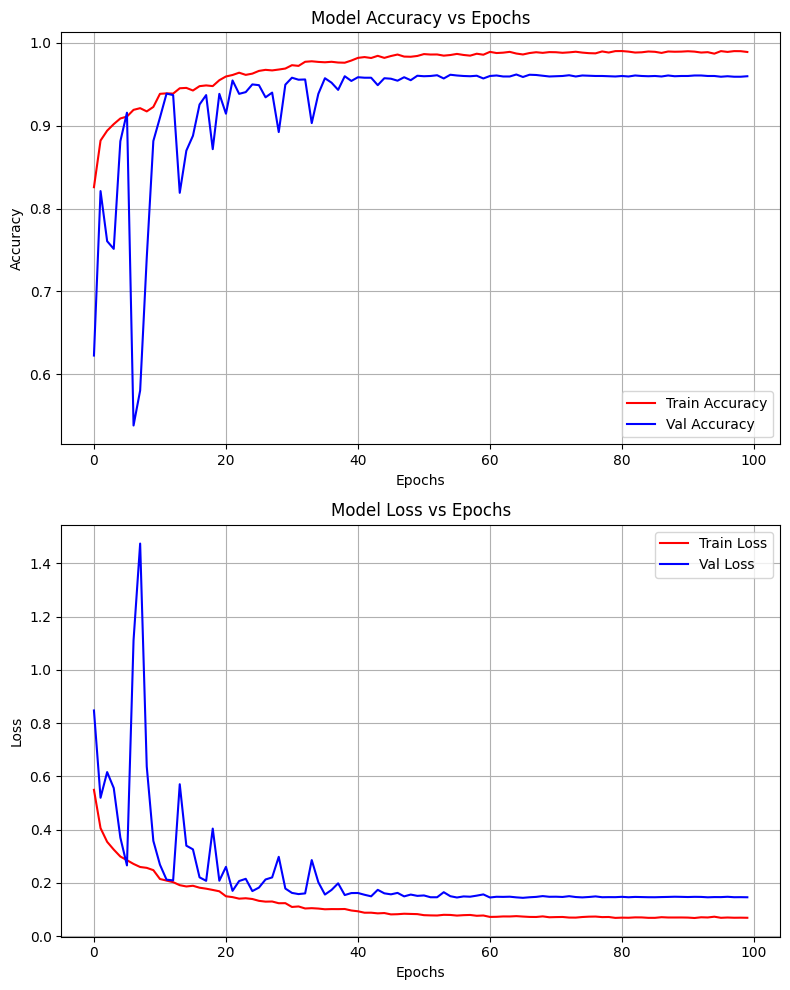

In [ ]:
import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow as tf

# Customize Adam Optimizer
def customizeAdam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
    return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

# Learning Rate Schedule Function
def lr_schedule(epoch, lr):
    return 0.001 * (0.5 ** (epoch // 10))

# Plotting Function
def plot_training_history(history):
    plt.figure(figsize=(8, 10))

    # Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')
    plt.title('Model Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], color='red', label='Train Loss')
    plt.plot(history.history['val_loss'], color='blue', label='Val Loss')
    plt.title('Model Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Main training function
def main():
    path = "apnea-ecg.pkl"  # Path to preprocessed dataset

    # Load preprocessed data
    x_train, _, _, y_train, _, x_val, _, _, y_val, _, x_test, _, _, y_test, _ = load_data(path)

    # One-hot encode labels
    y_train = keras.utils.to_categorical(y_train, num_classes=2)
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    # Create model
    model = resnet1d(input_shape=x_train.shape[1:])

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=customizeAdam(),
        metrics=['accuracy']
    )

    # Callbacks
    checkpoint = ModelCheckpoint('weights.best.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

    # Train model
    history = model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=100,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, lr_scheduler],
        verbose=2
    )

    # Plot training history
    plot_training_history(history)

    # Load best model and evaluate on test data
    model = load_model('weights.best.keras')
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

# Run
if __name__ == "__main__":
    main()


530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step


<Figure size 600x600 with 0 Axes>

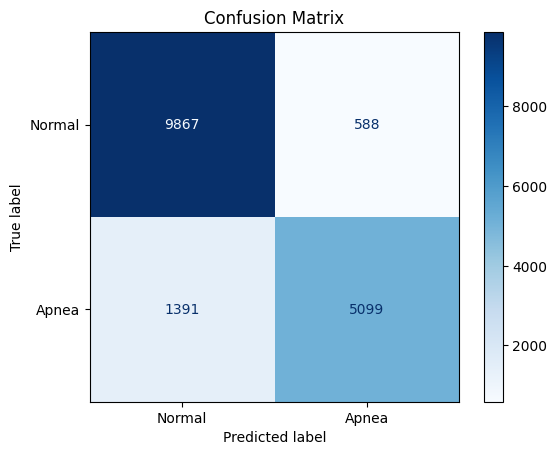

Classification Report:

              precision    recall  f1-score   support

      Normal       0.88      0.94      0.91     10455
       Apnea       0.90      0.79      0.84      6490

    accuracy                           0.88     16945
   macro avg       0.89      0.86      0.87     16945
weighted avg       0.88      0.88      0.88     16945



In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from keras.models import load_model

# Load test data
path = "apnea-ecg.pkl"  # Path to preprocessed dataset
x_train, _, _, y_train, _, x_val, _, _, y_val, _, x_test, _, _, y_test, _ = load_data(path)

# One-hot encode labels
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Load best saved model
model = load_model('weights.best.keras')

# Predict
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Apnea"])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Apnea"]))


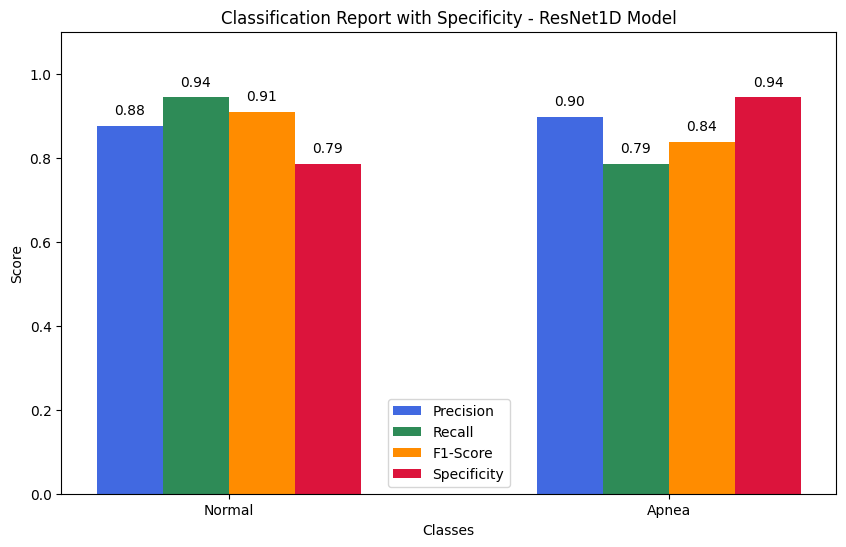

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot classification metrics including specificity
def plot_classification_report_bar(y_true, y_pred, class_names=['Normal', 'Apnea']):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate specificity for each class
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Gather metrics
    metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
    values = np.array([
        [report[label]['precision'], report[label]['recall'], report[label]['f1-score'], specificity[i]] 
        for i, label in enumerate(class_names)
    ])

    # Plotting setup
    colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']
    x = np.arange(len(class_names))
    width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        bars = ax.bar(x + i * width, values[:, i], width, label=metric, color=color)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}',
                    ha='center', va='bottom', fontsize=10)

    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Score")
    ax.set_title("Classification Report with Specificity - ResNet1D Model")
    ax.legend()
    plt.show()

# Example usage after model evaluation
# Assumes you already have y_pred and y_true computed like this:
# y_pred_probs = model.predict(x_test)
# y_pred = np.argmax(y_pred_probs, axis=1)
# y_true = np.argmax(y_test, axis=1)

plot_classification_report_bar(y_true, y_pred)


C:\Users\mital\AppData\Local\Temp\ipykernel_3504\4188525590.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


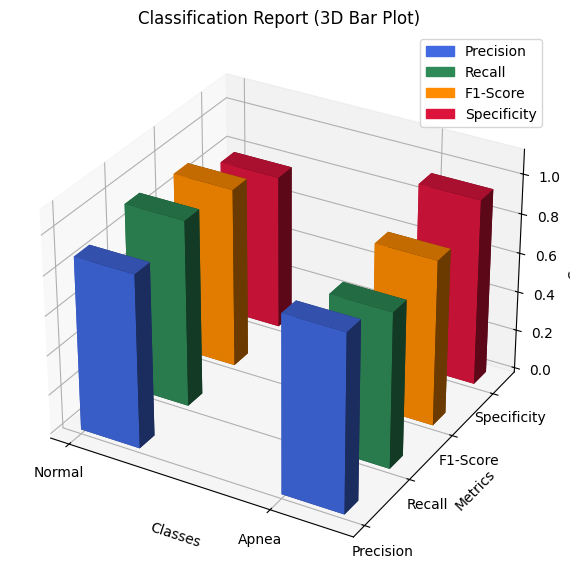

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

def plot_classification_report_3d(y_true, y_pred, class_names=['Normal', 'Apnea']):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate Specificity manually
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Collect metric values
    metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
    values = np.array([
        [report[label]['precision'], report[label]['recall'], report[label]['f1-score'], specificity[i]] 
        for i, label in enumerate(class_names)
    ])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Bar positions
    x_pos = np.arange(len(class_names))
    y_pos = np.arange(len(metrics))
    x_pos, y_pos = np.meshgrid(x_pos, y_pos)
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = np.zeros_like(x_pos)

    dx = dy = 0.3
    dz = values.T.flatten()

    # Color map per metric (same color across all classes)
    metric_colors = {
        'Precision': 'royalblue',
        'Recall': 'seagreen',
        'F1-Score': 'darkorange',
        'Specificity': 'crimson'
    }
    bar_colors = [metric_colors[metrics[y]] for y in y_pos]

    # Plot
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, shade=True)

    # Axes Labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(len(metrics)))
    ax.set_yticklabels(metrics)
    ax.set_zlim(0, 1.1)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Metrics")
    ax.set_zlabel("Scores")
    ax.set_title("Classification Report (3D Bar Plot)")

    # Legend
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color=color, label=metric) for metric, color in metric_colors.items()]
    ax.legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()
    plt.show()

# ✅ Example usage (after prediction)
# y_pred = np.argmax(model.predict(x_test), axis=1)
# y_true = np.argmax(y_test, axis=1)

plot_classification_report_3d(y_true, y_pred)


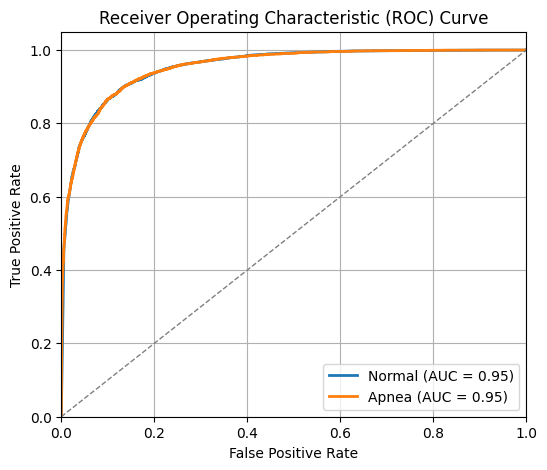

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curves for both classes (Normal vs Apnea)
def plot_roc_curve(y_true, y_pred_prob, class_names=['Normal', 'Apnea']):
    plt.figure(figsize=(6, 5))

    for i, class_name in enumerate(class_names):
        # Generate ROC curve for each class (Normal -> 0, Apnea -> 1)
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])  # One-hot encoded y_true, class-wise probabilities
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Reference line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    # Labels and Title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example usage after training model:
# Assuming y_test is one-hot encoded and y_pred_prob contains predicted probabilities
plot_roc_curve(y_test, y_pred_prob)
